In [1]:
### READ ME ###

# Last Updated 4/14/2021

# Best-Fit Mapping allows the user to generate attribute maps that limit interpolation to a user-defined error threshold
# Code accepts .csv files and is hard-coded to accept certain column names (see below)
# Code outputs .csv's 1) mapped point data 2) best fit grid 3) smoothed grid 4) mapped point data with sampled grid values
# Code outputs .jpg's for maps and select plots
# User must edit code blocks to import csv, and export to a specified folder

# Hard coded column names (captialization required):
#### Required column names: X, Y or LAT, LON
#### Nonrequired utilized column names: UWI, ISO (Isopach)
#### Curve footages > 0 with '_GT0' in column name will be used with ISO to calculate curve coverage (not required)
#### Curve attributes will be binned appropriately when named starting with: GR, RESD, PHIN, PHID, DTC, DRHO (not required)
# Hard coded shapefiles for counties and faults
# Toggle for .jpg popups

In [172]:
import geopandas as gpd
from geopandas import *
from shapely.geometry import Polygon
import numpy as np
np.warnings.filterwarnings('ignore')
import pandas as pd
import math
import matplotlib.pyplot as plt
import itertools
from scipy.spatial import cKDTree, KDTree
from statistics import mean
import re
from pathlib import Path, PureWindowsPath
import webbrowser
from pyproj import Transformer, Proj, CRS

In [173]:
###############################
### ***Linked Shapefiles*** ###
###############################
file_path = "W:/Geology/EAR/Python/BEST_FIT_MAPPING/MAPS/"

cnty_shapefile = gpd.read_file("W:/Geology/EAR/GIS/Personal_Shapes/County.shp")
flt_shapefile = gpd.read_file("W:/Geology/EAR/GIS/Personal_Shapes/Permian_Basement_Faults.shp")
#prj_aoi = gpd.read_file("W:\Geology\EAR\GIS\Personal_Shapes\Boundingbox")

In [174]:
####################################
### ***TOGGLES FOR JPG POPUPS*** ###
####################################
# 1 for popup, 0 for none
outlier_popup = 0
bf_popup = 1
smth_popup = 1
cfp_popup = 0

In [175]:
class tree(object):
    def __init__(self, X=None, z=None, leafsize=10):
        if not X is None:
            self.tree = cKDTree(X, leafsize=leafsize )
        if not z is None:
            self.z = np.array(z)

    def fit(self, X=None, z=None, leafsize=10):
        return self.__init__(X, z, leafsize)

    def __call__(self, X, k=6, eps=1e-6, p=2, regularize_by=1e-9):
        self.distances, self.idx = self.tree.query(X, k, eps=eps, p=p)
        self.distances += regularize_by
        weights = self.z[self.idx.ravel()].reshape(self.idx.shape)
        mw = np.sum(weights/self.distances, axis=1) / np.sum(1./self.distances, axis=1)
        return mw

    def transform(self, X, k=6, p=2, eps=1e-6, regularize_by=1e-9):
        return self.__call__(X, k, eps, p, regularize_by)

def merge(list1, list2):    
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return np.array(merged_list)

In [236]:
################################
### ***LINKED DATA TABLES*** ###
################################

rawdata = pd.read_csv(file_path + 'BS3_Shale.csv')
display(rawdata)

,UWI,Surface X,Surface Y,ZoneAttrName,Value
0,42301313330000,1042384.29,755762.28,TVT,72.28
1,42301313330000,1042384.29,755762.28,MIN_GR,24.55
2,42301313330000,1042384.29,755762.28,MAX_GR,122.86
3,42301313330000,1042384.29,755762.28,ARITH_MEAN_GR,69.60
4,42301313330000,1042384.29,755762.28,MIN_DTWS,53.28
...,...,...,...,...,...
1606,42475309640000,1086832.17,716439.17,MAX_GR,106.56
1607,42475309640000,1086832.17,716439.17,ARITH_MEAN_GR,60.99
1608,42475309640000,1086832.17,716439.17,MIN_DTWS,55.63
1609,42475309640000,1086832.17,716439.17,MAX_DTWS,88.00


In [237]:
values = rawdata.pivot(index='UWI', columns='ZoneAttrName', values="Value")
data = values.join(rawdata.drop_duplicates(subset=['UWI']).set_index('UWI'), how='inner')
data

,ARITH_MEAN_DTWS,ARITH_MEAN_GR,ARITH_MEAN_RT,MAX_DTWS,MAX_GR,MAX_RT,MIN_DTWS,MIN_GR,MIN_RT,TVT,Surface X,Surface Y,ZoneAttrName,Value
UWI,,,,,,,,,,,,,,
42301300090000,74.23,52.45,38.43,92.76,72.13,272.06,55.78,28.91,9.61,70.21,1004421.80,744982.08,TVT,70.21
42301300190000,74.82,54.78,55.63,94.96,79.69,341.62,55.93,27.46,13.83,70.12,1003156.98,739224.45,TVT,70.12
42301301000000,74.90,52.06,41.55,95.38,77.45,498.41,54.60,23.30,9.72,73.18,1024460.36,759023.54,TVT,73.18
42301301970000,74.76,54.22,40.81,93.14,86.21,206.04,53.73,21.93,12.03,76.55,1039435.84,735120.32,TVT,76.55
42301302860000,73.97,NaN,NaN,89.73,NaN,NaN,54.50,NaN,NaN,73.81,1043992.85,766560.40,TVT,73.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42495332600000,73.97,65.70,NaN,88.93,109.35,NaN,53.73,30.43,NaN,76.26,1076147.82,743606.64,TVT,76.26
42495332610000,76.93,71.94,NaN,91.99,121.81,NaN,54.72,31.33,NaN,74.26,1077946.20,746883.50,TVT,74.26
42495332630000,74.00,72.84,NaN,86.12,123.89,NaN,53.90,28.23,NaN,77.06,1071870.15,755270.20,TVT,77.06


In [238]:
data.rename(columns={'Surface X': 'X',
                    'Surface Y': 'Y',
                    'SurfLat': 'Lat_Orig',
                    'SurfLong': 'Long_Orig',
                    'TVT': 'ISO',
                    'ARITH_MEAN_DTWS': 'DTC_MN',
                    'ARITH_MEAN_GR': 'GR_MN',
                    'ARITH_MEAN_RT': 'RESD_MN',
                    },
           inplace=True)
data.drop(['ZoneAttrName', 'Value'], axis=1, inplace=True)
data.head()

,DTC_MN,GR_MN,RESD_MN,MAX_DTWS,MAX_GR,MAX_RT,MIN_DTWS,MIN_GR,MIN_RT,ISO,X,Y
UWI,,,,,,,,,,,,
42301300090000,74.23,52.45,38.43,92.76,72.13,272.06,55.78,28.91,9.61,70.21,1004421.80,744982.08
42301300190000,74.82,54.78,55.63,94.96,79.69,341.62,55.93,27.46,13.83,70.12,1003156.98,739224.45
42301301000000,74.90,52.06,41.55,95.38,77.45,498.41,54.60,23.30,9.72,73.18,1024460.36,759023.54
42301301970000,74.76,54.22,40.81,93.14,86.21,206.04,53.73,21.93,12.03,76.55,1039435.84,735120.32
42301302860000,73.97,NaN,NaN,89.73,NaN,NaN,54.50,NaN,NaN,73.81,1043992.85,766560.40


In [239]:
col_lst = []

for col in data.columns:
    print(col)
    col_lst.append(col)
    
if 'LAT' in col_lst and 'LON' in col_lst and 'X' in col_lst and 'Y' in col_lst:
    print('Location data ready')
    
elif 'X' in col_lst and 'Y' in col_lst and 'LAT' not in col_lst and 'LON' not in col_lst:
    print('Converting XY to Lat/Long...')
    
    #Convert xy to lat long
    inproj = 32040
    outproj = 4267
    transformer = Transformer.from_crs(inproj, outproj)
    xin, yin = data['X'].tolist(), data['Y'].tolist()
    latout, lonout = transformer.transform(xin, yin)
    data['LAT'] = latout
    data['LON'] = lonout
    
elif 'LAT' in col_lst and 'LON' in col_lst and 'X' not in col_lst and 'Y' not in col_lst:
    print('Converting Lat/Long to XY...')
    
    #Convert lat long to xy
    inproj = 4267
    outproj = 32040
    print('check and check')
    transformer = Transformer.from_crs(inproj, outproj, always_xy=True)
    lonin = data['LON'].tolist()
    latin = data['LAT'].tolist()
    xout, yout = transformer.transform(lonin, latin)
    data['X'] = xout
    data['Y'] = yout
    
else:
    print('Insufficient location data.')
    
    
# COMMON EPSG CODES
#   NAD27 LAT LONG          =   4267
#   NAD27 TX CENTRAL US-FT  =   32039
#   NAD27 TX S CENTRAL US-FT = 32040
#   NAD27 LA NORTH US-FT    =   26781

data.describe()

DTC_MN
GR_MN
RESD_MN
MAX_DTWS
MAX_GR
MAX_RT
MIN_DTWS
MIN_GR
MIN_RT
ISO
X
Y
Converting XY to Lat/Long...


,DTC_MN,GR_MN,RESD_MN,MAX_DTWS,MAX_GR,MAX_RT,MIN_DTWS,MIN_GR,MIN_RT,ISO,X,Y,LAT,LON
count,169.000000,180.000000,124.000000,169.000000,180.000000,124.000000,169.000000,180.000000,124.000000,192.000000,2.040000e+02,204.000000,204.000000,204.000000
mean,73.787101,59.041500,64.066129,90.052071,96.691944,623.565403,54.355385,26.642333,15.079274,74.743906,1.058337e+06,726582.701569,29.798765,-101.969323
std,8.887144,14.435935,40.655358,11.685127,25.405399,585.817857,7.291156,7.045167,10.710910,8.355966,2.837274e+04,27194.329194,0.074616,0.089635
min,0.000000,17.300000,20.540000,0.000000,26.860000,50.030000,0.000000,8.820000,0.200000,15.120000,1.003157e+06,674018.900000,29.653871,-102.144303
25%,72.430000,49.537500,47.477500,87.100000,79.120000,265.727500,53.240000,23.245000,11.370000,72.107500,1.039131e+06,703026.075000,29.735483,-102.031372
50%,73.670000,59.765000,57.005000,89.170000,99.095000,415.935000,54.160000,26.000000,13.160000,74.100000,1.058655e+06,724786.980000,29.794317,-101.970623
75%,74.820000,69.467500,67.047500,91.680000,115.682500,785.607500,55.200000,29.147500,16.505000,76.875000,1.082307e+06,750812.562500,29.866721,-101.892503
max,134.540000,118.830000,432.530000,160.030000,179.710000,3869.260000,111.490000,52.560000,122.240000,99.050000,1.108711e+06,770163.070000,29.920210,-101.807569


In [240]:
col_lst = []
new_col = 'blah'
print('Columns to import: ')

for col in data.columns:
    print(col)
    col_lst.append(col)

man_lst = input('Use auto-generated list?: (Y- yes, N- start manual selection)')
if man_lst == 'N':
    col_lst = []
    while True:
        new_col = input('Enter name of attribue to import: (inclue X & Y, d for done)')
        if new_col == 'd': break        
        col_lst.append(new_col)
    print('Manually entered columns to import:\n', col_lst)


Columns to import: 
DTC_MN
GR_MN
RESD_MN
MAX_DTWS
MAX_GR
MAX_RT
MIN_DTWS
MIN_GR
MIN_RT
ISO
X
Y
LAT
LON
Use auto-generated list?: (Y- yes, N- start manual selection)Y


In [241]:
#Categorize Attributes by curve name & log transform RESD MN properties

GR_crvs = ['UWI', 'X', 'Y', 'LAT', 'LON', 'ISO']
RESD_crvs = ['UWI', 'X', 'Y', 'LAT', 'LON', 'ISO']
PHIN_crvs = ['UWI', 'X', 'Y', 'LAT', 'LON', 'ISO']
PHID_crvs = ['UWI', 'X', 'Y', 'LAT', 'LON', 'ISO']
DTC_crvs = ['UWI', 'X', 'Y', 'LAT', 'LON', 'ISO']

for col in col_lst:
    crv_match = re.findall('^GR_*', col)
    if len(crv_match) > 0:
        GR_crvs.append(col)
print('GR Curve Attributes: ', GR_crvs)

for col in col_lst:
    crv_match = re.findall('^RESD_*', col)
    if len(crv_match) > 0:
        RESD_crvs.append(col)
    resd_mn_match = re.findall('RESD.+MN', str(col))
    if len(resd_mn_match) > 0:
        new_col = str(col) + '_LOG'
        data[new_col] = np.log10(data[col])
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        RESD_crvs.append(new_col)
print('RESD Curve Attributes: ', RESD_crvs)

for col in col_lst:
    crv_match = re.findall('^PHIN_*', col)
    if len(crv_match) > 0:
        PHIN_crvs.append(col)
print('PHIN Curve Attributes: ', PHIN_crvs)

for col in col_lst:
    crv_match = re.findall('^PHID_*', col)
    if len(crv_match) > 0:
        PHID_crvs.append(col)
print('PHID Curve Attributes: ', PHID_crvs)

for col in col_lst:
    crv_match = re.findall('^DTC_*', col)
    if len(crv_match) > 0:
        DTC_crvs.append(col)
print('DTC Curve Attributes: ', DTC_crvs)

GR Curve Attributes:  ['UWI', 'X', 'Y', 'LAT', 'LON', 'ISO', 'GR_MN']
RESD Curve Attributes:  ['UWI', 'X', 'Y', 'LAT', 'LON', 'ISO', 'RESD_MN', 'RESD_MN_LOG']
PHIN Curve Attributes:  ['UWI', 'X', 'Y', 'LAT', 'LON', 'ISO']
PHID Curve Attributes:  ['UWI', 'X', 'Y', 'LAT', 'LON', 'ISO']
DTC Curve Attributes:  ['UWI', 'X', 'Y', 'LAT', 'LON', 'ISO', 'DTC_MN']


In [242]:
#Calculate NTG and coverage for GT/LT attributes (gross properties and 'PAY_NT')

crv_lst_lst = []
crv_lst_lst.append(GR_crvs)
crv_lst_lst.append(RESD_crvs)
crv_lst_lst.append(PHIN_crvs)
crv_lst_lst.append(PHID_crvs)
crv_lst_lst.append(DTC_crvs)

if 'ISO' in data:
    for crv_lst_ in crv_lst_lst:
        for prop in crv_lst_:
            GT_match = re.findall('_[A-Z]T[0-9]+$', str(prop))
            if len(GT_match) > 0:
                gross_att_match = re.findall('_[A-Z]T0$', str(prop))
                if len(gross_att_match) > 0:
                    cov_nm = str(prop)
                    cov_nm = cov_nm.split('_')
                    cov_nm = cov_nm[0]
                    cov_nm = str(cov_nm + '_COV')
                    data[cov_nm] = data[prop]/data['ISO']
                    data.loc[(data[cov_nm] > 1), cov_nm] = 1
                    
                    if prop.split('_')[0] == 'GR':
                        GR_crvs.append(cov_nm)
                    if prop.split('_')[0] == 'RESD':
                        RESD_crvs.append(cov_nm)
                    if prop.split('_')[0] == 'PHIN':
                        PHIN_crvs.append(cov_nm)
                    if prop.split('_')[0] == 'PHID':
                        PHID_crvs.append(cov_nm)
                    if prop.split('_')[0] == 'DTC':
                        DTC_crvs.append(cov_nm)
                else:
                    NTG_var_nm = str(prop) + '_NTG'
                    data[NTG_var_nm] = data[prop]/data['ISO']
                    data.loc[(data[NTG_var_nm] > 1), NTG_var_nm] = 1
                    
                    if prop.split('_')[0] == 'GR':
                        GR_crvs.append(NTG_var_nm)
                    if prop.split('_')[0] == 'RESD':
                        RESD_crvs.append(NTG_var_nm)
                    if prop.split('_')[0] == 'PHIN':
                        PHIN_crvs.append(NTG_var_nm)
                    if prop.split('_')[0] == 'PHID':
                        PHID_crvs.append(NTG_var_nm)
                    if prop.split('_')[0] == 'DTC':
                        DTC_crvs.append(NTG_var_nm)

else:
    
    if len(GR_crvs) > 0:
        data['GR_COV'] = 1
        GR_crvs.append('GR_COV')
    
    if len(RESD_crvs) > 0:
        data['RESD_COV'] = 1
        RESD_crvs.append('RESD_COV')
        
    if len(PHIN_crvs) > 0:
        data['PHIN_COV'] = 1
        PHIN_crvs.append('PHIN_COV')
        
    if len(PHID_crvs) > 0:
        data['PHID_COV'] = 1
        PHID_crvs.append('PHID_COV')
    
    if len(DTC_crvs) > 0:
        data['DTC_COV'] = 1
        DTC_crvs.append('DTC_COV')   
        
if ('ISO' in data) & ('PAY' in data):
    data['PAY_NTG'] = data['PAY']/data['ISO']
    data.loc[(data['PAY_NTG'] > 1), 'PAY_NTG'] = 1
                    
display(data.describe())

display('GR Curve Attributes: ', GR_crvs)
display('RESD Curve Attributes: ', RESD_crvs)
display('PHIN Curve Attributes: ', PHIN_crvs)
display('PHID Curve Attributes: ', PHID_crvs)
display('DTC Curve Attributes: ', DTC_crvs)

,DTC_MN,GR_MN,RESD_MN,MAX_DTWS,MAX_GR,MAX_RT,MIN_DTWS,MIN_GR,MIN_RT,ISO,X,Y,LAT,LON,RESD_MN_LOG
count,169.000000,180.000000,124.000000,169.000000,180.000000,124.000000,169.000000,180.000000,124.000000,192.000000,2.040000e+02,204.000000,204.000000,204.000000,124.000000
mean,73.787101,59.041500,64.066129,90.052071,96.691944,623.565403,54.355385,26.642333,15.079274,74.743906,1.058337e+06,726582.701569,29.798765,-101.969323,1.765566
std,8.887144,14.435935,40.655358,11.685127,25.405399,585.817857,7.291156,7.045167,10.710910,8.355966,2.837274e+04,27194.329194,0.074616,0.089635,0.171504
min,0.000000,17.300000,20.540000,0.000000,26.860000,50.030000,0.000000,8.820000,0.200000,15.120000,1.003157e+06,674018.900000,29.653871,-102.144303,1.312600
25%,72.430000,49.537500,47.477500,87.100000,79.120000,265.727500,53.240000,23.245000,11.370000,72.107500,1.039131e+06,703026.075000,29.735483,-102.031372,1.676488
50%,73.670000,59.765000,57.005000,89.170000,99.095000,415.935000,54.160000,26.000000,13.160000,74.100000,1.058655e+06,724786.980000,29.794317,-101.970623,1.755911
75%,74.820000,69.467500,67.047500,91.680000,115.682500,785.607500,55.200000,29.147500,16.505000,76.875000,1.082307e+06,750812.562500,29.866721,-101.892503,1.826379
max,134.540000,118.830000,432.530000,160.030000,179.710000,3869.260000,111.490000,52.560000,122.240000,99.050000,1.108711e+06,770163.070000,29.920210,-101.807569,2.636016


'GR Curve Attributes: '

['UWI', 'X', 'Y', 'LAT', 'LON', 'ISO', 'GR_MN']

'RESD Curve Attributes: '

['UWI', 'X', 'Y', 'LAT', 'LON', 'ISO', 'RESD_MN', 'RESD_MN_LOG']

'PHIN Curve Attributes: '

['UWI', 'X', 'Y', 'LAT', 'LON', 'ISO']

'PHID Curve Attributes: '

['UWI', 'X', 'Y', 'LAT', 'LON', 'ISO']

'DTC Curve Attributes: '

['UWI', 'X', 'Y', 'LAT', 'LON', 'ISO', 'DTC_MN']

array([[<AxesSubplot:title={'center':'DTC_MN'}>,
        <AxesSubplot:title={'center':'GR_MN'}>,
        <AxesSubplot:title={'center':'RESD_MN'}>,
        <AxesSubplot:title={'center':'MAX_DTWS'}>],
       [<AxesSubplot:title={'center':'MAX_GR'}>,
        <AxesSubplot:title={'center':'MAX_RT'}>,
        <AxesSubplot:title={'center':'MIN_DTWS'}>,
        <AxesSubplot:title={'center':'MIN_GR'}>],
       [<AxesSubplot:title={'center':'MIN_RT'}>,
        <AxesSubplot:title={'center':'ISO'}>,
        <AxesSubplot:title={'center':'X'}>,
        <AxesSubplot:title={'center':'Y'}>],
       [<AxesSubplot:title={'center':'LAT'}>,
        <AxesSubplot:title={'center':'LON'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

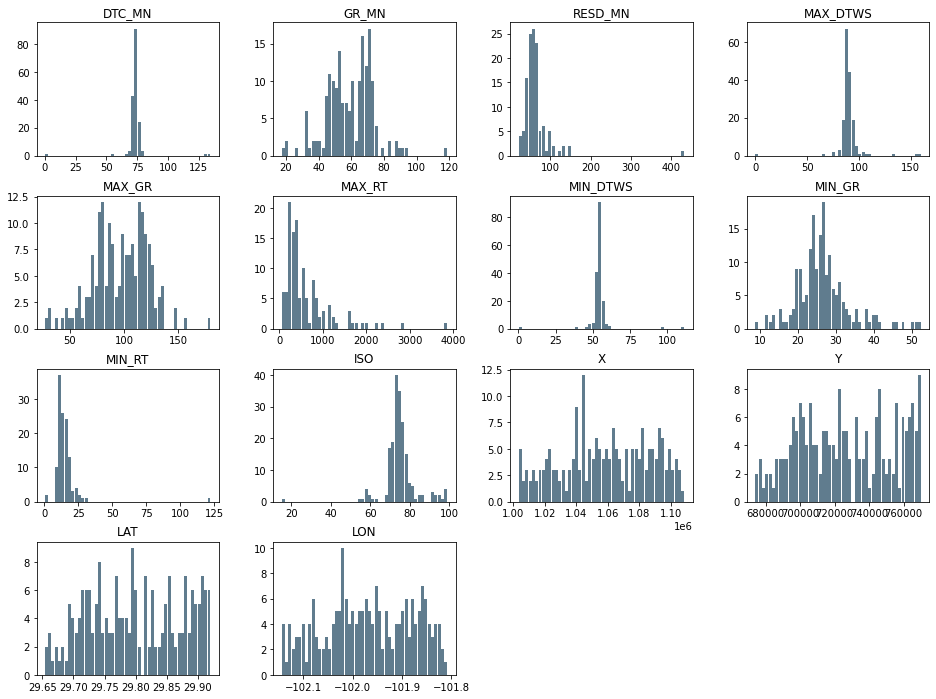

In [243]:
#view histograms of data
data.hist(column=col_lst, bins=50, grid=False, figsize=(16,12), color='#607c8e', zorder=2, rwidth=0.9)

In [244]:
#Convert incorrectly aliased curves and populate missing PHID_MN data with calculation from RHOB_MN and viceversa
if set(['PHID_MN', 'RHOB_MN']).issubset(data.columns):
    data.loc[data['PHID_MN'] > 2.0, 'PHID_MN'] = (data['PHID_MN']-2.71)/(1-2.71)
    data.loc[data['RHOB_MN'] < 2.0, 'RHOB_MN'] = (1-data['RHOB_MN'])*2.65*data['RHOB_MN']

    data['PHID_MN'] = data['PHID_MN'].fillna((data['RHOB_MN']-2.71)/(1-2.71))
    data['PHID_COV'] = data['PHID_COV'].fillna((data['RHOB_COV']))
    data['RHOB_MN'] = data['RHOB_MN'].fillna(data['PHID_MN']*1+(1-data['PHID_MN'])*2.65)
    data['RHOB_COV'] = data['RHOB_COV'].fillna((data['PHID_COV']))

    data.loc[data['RHOB_MN'] < 2.0,'RHOB_MN'] = (1-data['RHOB_MN'])*2.65*data['RHOB_MN']
    
    #view updated histograms of data
    data.hist(column=col_lst, bins=50, grid=False, figsize=(16,12), color='#607c8e', zorder=2, rwidth=0.9)

In [202]:
user_LOGCOV_PCT = 0.8

all_atts={}
map_crv_lst = []
map_crv_att_lst = []
other_lst = ['UWI', 'X', 'Y']
other_lst_len = 3
if 'ISO' in data:
    other_lst.append('ISO')
    other_lst_len = 4

if len(GR_crvs) > 6:
    GR_data = data[data.columns.intersection(GR_crvs)]
    GR_data = GR_data[(GR_data['GR_COV'] != None) & (GR_data['GR_COV']>= user_LOGCOV_PCT)]
    all_atts['GR'] = 'GR'
    all_atts['GR'] = [i for i in GR_data.columns]
    print(GR_data)
    map_crv_lst.append('GR')
    for a in GR_crvs:
        map_crv_att_lst.append(a)
    
if len(RESD_crvs) > 6:
    RESD_data = data[data.columns.intersection(RESD_crvs)]
    RESD_data = RESD_data[RESD_data['RESD_COV']>= user_LOGCOV_PCT]
    all_atts['RESD'] = 'RESD'
    all_atts['RESD'] = [i for i in RESD_data.columns]
    map_crv_lst.append('RESD')
    for a in RESD_crvs:
        map_crv_att_lst.append(a)
        
if len(PHIN_crvs) > 6:
    PHIN_data = data[data.columns.intersection(PHIN_crvs)]
    PHIN_data = PHIN_data[PHIN_data['PHIN_COV']>= user_LOGCOV_PCT]
    all_atts['PHIN'] = 'PHIN'
    all_atts['PHIN'] = [i for i in PHIN_data.columns]
    map_crv_lst.append('PHIN')
    for a in PHIN_crvs:
        map_crv_att_lst.append(a)
        
if len(PHID_crvs) > 6:
    PHID_data = data[data.columns.intersection(PHID_crvs)]
    PHID_data = PHID_data[PHID_data['PHID_COV']>= user_LOGCOV_PCT]
    all_atts['PHID'] = 'PHID'
    all_atts['PHID'] = [i for i in PHID_data.columns]
    map_crv_lst.append('PHID')
    for a in PHID_crvs:
        map_crv_att_lst.append(a)
        
if len(DTC_crvs) > 6:
    DTC_data = data[data.columns.intersection(DTC_crvs)]
    DTC_data = DTC_data[DTC_data['DTC_COV']>= user_LOGCOV_PCT]
    all_atts['DTC'] = 'DTC'
    all_atts['DTC'] = [i for i in DTC_data.columns]
    map_crv_lst.append('DTC')
    for a in DTC_crvs:
        map_crv_att_lst.append(a)
        
col_lst = []
for col in data.columns:
    col_lst.append(col)
        
for el in col_lst:
    if el not in map_crv_att_lst:
        other_lst.append(el)

if len(other_lst) > other_lst_len:
    other_data = data[data.columns.intersection(other_lst)]
    all_atts['OTHER'] = 'OTHER'
    all_atts['OTHER'] = [i for i in other_data.columns]
    map_crv_lst.append('OTHER')

print('Curves with attributes available to map: ')
for c in map_crv_lst:
    print(c)

KeyError: 'GR_COV'

Enter desired geologic attribute: GR_MN


array([[<AxesSubplot:title={'center':'GR_MN'}>]], dtype=object)

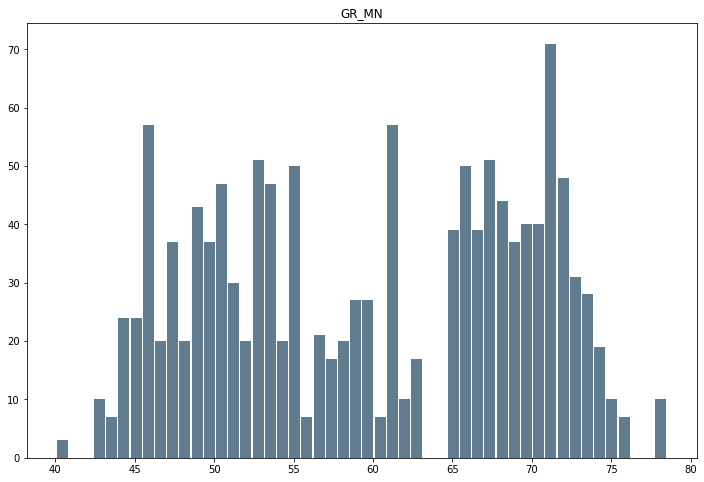

In [246]:
#Choose attribute to analyze
geoatt = input('Enter desired geologic attribute: ')
df_choice.hist(column=[geoatt], bins=50, grid=False, figsize=(12,8), color='#607c8e', zorder=2, rwidth=0.9)

Enter additional filter min: (Press Return for none) 40
Enter additional filter max: (Press Return for none) 80


array([[<AxesSubplot:title={'center':'GR_MN'}>]], dtype=object)

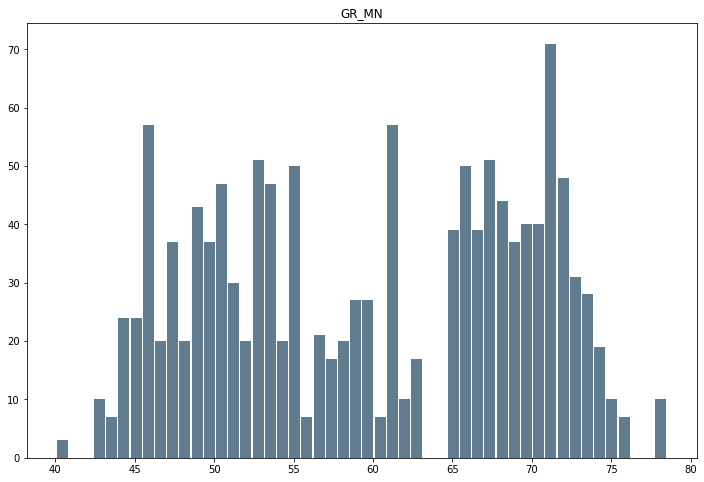

In [247]:
add_filter_min = input('Enter additional filter min: (Press Return for none) ')
if len(add_filter_min) < 1: add_filter_min = df_choice[geoatt].min()
add_filter_max = input('Enter additional filter max: (Press Return for none) ')
if len(add_filter_max) < 1: add_filter_max = df_choice[geoatt].max()

df_choice = df_choice[(df_choice[geoatt]>=float(add_filter_min)) & (df_choice[geoatt]<=float(add_filter_max))]
#print(df_choice.head(20))
df_choice.hist(column=[geoatt], bins=50, grid=False, figsize=(12,8), color='#607c8e', zorder=2, rwidth=0.9)

In [249]:
map_data

,GR_MN,X,Y,NN_DIST
UWI,,,,
42301300090000,52.45,1004421.80,744982.08,0.0
42301300090000,52.45,1004421.80,744982.08,0.0
42301300090000,52.45,1004421.80,744982.08,0.0
42301300090000,52.45,1004421.80,744982.08,0.0
42301300090000,52.45,1004421.80,744982.08,0.0
...,...,...,...,...
42495332720000,71.60,1075097.72,737793.38,0.0
42495332720000,71.60,1075097.72,737793.38,0.0
42495332720000,71.60,1075097.72,737793.38,0.0


Number of data points:  1321
0.0 - minimum distance between nearest neighbors
0.0 - mean distance between nearest neighbors
0.0 - maximum distance between nearest neighbors
0.0 - prescribed grid node spacing


OverflowError: cannot convert float infinity to integer

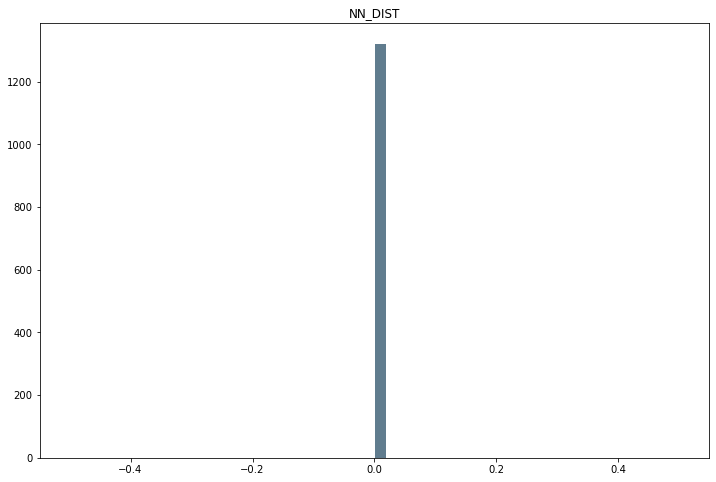

In [248]:
#Calculate average distance between data points

if 'UWI' in col_lst:
    map_data = df_choice[['UWI', geoatt, 'X', 'Y']]
else:
    map_data = df_choice[[geoatt, 'X', 'Y']]
map_data = map_data.dropna()
print('Number of data points: ', len(map_data))

data_dist = map_data[['X', 'Y']]
data_dist_array = data_dist.to_numpy()

dist_tree = KDTree(data_dist_array)
dist, ind = dist_tree.query(data_dist_array, k=2)

map_data['NN_DIST'] = dist[:,1]
map_data.hist(column=['NN_DIST'], bins=50, grid=False, figsize=(12,8), color='#607c8e', zorder=2, rwidth=0.9)
print(round(map_data['NN_DIST'].min(), 1), '- minimum distance between nearest neighbors')
print(round(map_data['NN_DIST'].mean(), 1), '- mean distance between nearest neighbors')
print(round(map_data['NN_DIST'].max(), 1), '- maximum distance between nearest neighbors')
print(round(map_data['NN_DIST'].mean()/4, 1), '- prescribed grid node spacing')
pres_x_cols = (map_data['X'].max()-map_data['X'].min())/(map_data['NN_DIST'].mean()/4)
pres_y_rows = (map_data['Y'].max()-map_data['Y'].min())/(map_data['NN_DIST'].mean()/4)
pres_ncol = (pres_x_cols+pres_y_rows)/2
print(int(pres_ncol), '- prescribed number of rows and columns')


In [ ]:
#perform trend surface outlier analysis
fm_nm = input('Enter formation name: ')
comm = input('Enter comment addition for file name: (Underscore before, Return for none) ')
order_inp = input('Enter desired trend order: ')
order_inp = int(order_inp)
user_ol_thresh = input('Enter desired percentile for outlier threshold: (0-1, 0.9, 0.95, etc)')
user_ol_thresh = float(user_ol_thresh)

ncol = input('Enter desired number of rows and columns: (Return uses prescribed values) ')
if len(ncol)< 1 :
    ncol = int(pres_ncol)
    nx, ny = int(ncol), int(ncol)
else:
    nx, ny = int(ncol), int(ncol)

def polyfit2d(x, y, z, order=order_inp):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m

def polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z += a * x**i * y**j
    return z

# Fit tight IDW grid of data
data_z = map_data[[geoatt]].to_numpy()
data_x = map_data[['X']].to_numpy()
data_y = map_data[['Y']].to_numpy()
if 'UWI' in col_lst:
    data_uwi = map_data[['UWI']].to_numpy()
red_data_z = data_z.reshape(len(data_z),)
red_data_x = data_x.reshape(len(data_z),)
red_data_y = data_y.reshape(len(data_z),)
if 'UWI' in col_lst:
    red_data_uwi = data_uwi.reshape(len(data_uwi),)

zxy = merge(red_data_x, red_data_y)
zval = red_data_z
idw_tree = tree(zxy, zval)

x_spacing = np.linspace(red_data_x.min()-10000, red_data_x.max()+10000, int(ncol))
y_spacing = np.linspace(red_data_y.min()-10000, red_data_y.max()+10000, int(ncol))
xy_grid = np.meshgrid(x_spacing, y_spacing)
grid_shape = xy_grid[0].shape
xy_grid = np.reshape(xy_grid, (2, -1)).T

z_idw = idw_tree(xy_grid)

# Fit an nth order, 2d polynomial
m = polyfit2d(xy_grid[:,0],xy_grid[:,1],z_idw)

# Evaluate it on a grid...
xx, yy = np.meshgrid(np.linspace(int(xy_grid[:,0].min()), int(xy_grid[:,0].max()), nx), 
                         np.linspace(int(xy_grid[:,1].min()), int(xy_grid[:,1].max()), ny))
zz = polyval2d(xx, yy, m)

#turn grid data into input points
zxy_rev = merge(xy_grid[:,0], xy_grid[:,1])
zval_rev = zz.reshape(int(ncol)**2,)

idw_tree_rev = tree(zxy_rev,zval_rev)

#perform idw in reverse
ts_smp = idw_tree_rev(zxy)

newvar = geoatt + '_TS' + str(order_inp)

if 'UWI' in col_lst:
    ts_grid = {'UWI': red_data_uwi, 'Y': red_data_y, 'X': red_data_x, geoatt: red_data_z, newvar: ts_smp}
else:
    ts_grid = {'Y': red_data_y, 'X': red_data_x, geoatt: red_data_z, newvar: ts_smp}
ts_grid_df = pd.DataFrame(data=ts_grid)
ts_diff_var = newvar + '_ABS_DIFF'
ts_grid_df[ts_diff_var] = abs(ts_grid_df[geoatt]-ts_grid_df[newvar])

ol_thresh = ts_grid_df[ts_diff_var].quantile(user_ol_thresh)
ol_remove = ts_grid_df[ts_grid_df[ts_diff_var]>ol_thresh]
ol_remain = ts_grid_df[ts_grid_df[ts_diff_var]<=ol_thresh]
    
ts_map_title = newvar

#generate new grid with outliers removed
olr_data_z = ol_remain[[geoatt]].to_numpy()
olr_data_x = ol_remain[['X']].to_numpy()
olr_data_y = ol_remain[['Y']].to_numpy()
olr_red_data_z = olr_data_z.reshape(len(olr_data_z),)
olr_red_data_x = olr_data_x.reshape(len(olr_data_z),)
olr_red_data_y = olr_data_y.reshape(len(olr_data_z),)

olr_zxy = merge(olr_red_data_x, olr_red_data_y)
olr_zval = olr_red_data_z
olr_idw_tree = tree(olr_zxy, olr_zval)

olr_z_idw = olr_idw_tree(xy_grid)


# Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharex=True, sharey=True, figsize=(25,25))
plot_title = 'Trend Surface Outlier Analysis\n\n Trend order: '+ str(order_inp) + ' \nOutlier percentile threshold: ' + str(user_ol_thresh)
fig.suptitle(plot_title, fontsize=18)
ax1.contourf(x_spacing, y_spacing, z_idw.reshape(grid_shape), cmap='CMRmap')
#ax1.scatter(red_data_x,red_data_y,c='black')
ax1.scatter(ol_remove.X, ol_remove.Y, c='lime', s=400, marker='x')
ax1.title.set_text('Honored Z Data')
ax3.contourf(x_spacing, y_spacing, zz.reshape(grid_shape), cmap='CMRmap')
ax3.scatter(red_data_x,red_data_y,c='black')
ax3.scatter(ol_remove.X, ol_remove.Y, c='lime', s=400, marker='x')
ax3.title.set_text('Trend Surface Grid')
ax4.contourf(x_spacing, y_spacing, zz.reshape(grid_shape), cmap='Greys')
ax4.scatter(red_data_x,red_data_y,c=ts_grid_df[ts_diff_var], cmap='YlOrRd')
ax4.scatter(ol_remove.X, ol_remove.Y, c='lime', s=400, marker='x')
ax4.title.set_text('Data Point TS Agreement')
ax2.title.set_text('Honored Z Data - Outliers Removed')
ax2.contourf(x_spacing, y_spacing, olr_z_idw.reshape(grid_shape), cmap='CMRmap')
ax2.scatter(red_data_x,red_data_y,c='black')

cnty_shapefile.plot(ax=ax1, facecolor="none", edgecolor='dimgrey')
cnty_shapefile.plot(ax=ax2, facecolor="none", edgecolor='dimgrey')
cnty_shapefile.plot(ax=ax3, facecolor="none", edgecolor='dimgrey')
cnty_shapefile.plot(ax=ax4, facecolor="none", edgecolor='dimgrey')
flt_shapefile2.plot(ax=ax1, facecolor="none", edgecolor='sienna')
flt_shapefile2.plot(ax=ax2, facecolor="none", edgecolor='sienna')
flt_shapefile2.plot(ax=ax3, facecolor="none", edgecolor='sienna')
flt_shapefile2.plot(ax=ax4, facecolor="none", edgecolor='sienna')
prj_aoi.plot(ax=ax1, facecolor="none", edgecolor='red', linewidth=2)
prj_aoi.plot(ax=ax2, facecolor="none", edgecolor='red', linewidth=2)
prj_aoi.plot(ax=ax3, facecolor="none", edgecolor='red', linewidth=2)
prj_aoi.plot(ax=ax4, facecolor="none", edgecolor='red', linewidth=2)


plt.xlim(red_data_x.min()-10000, red_data_x.max()+10000)
plt.ylim(red_data_y.min()-10000, red_data_y.max()+10000)

plot_nm = file_path + fm_nm + '_' + geoatt + '_TS_OUTLIERS' + str(comm) +'.jpg'
plot_nm1 = str(plot_nm)
new_path = PureWindowsPath(plot_nm1)
plt.savefig(plot_nm,bbox_inches='tight')    
if outlier_popup == 1:
    webbrowser.open(plot_nm)

plt.show()

print('\n', ts_grid_df.describe(percentiles= [.05, .1, .25, .5, .75,.9, .95]))

map_data = ts_grid_df.copy()
or_map_data = ts_grid_df[ts_grid_df[ts_diff_var]<=ol_thresh]
or_map_data.hist(column=[geoatt], bins=50, grid=False, figsize=(12,8), color='#607c8e', zorder=2, rwidth=0.9)

In [ ]:
#perform best-fit gridding of cleaned point data using IDW algorithm (https://github.com/paulbrodersen/inverse_distance_weighting/blob/master/idw.py)

map_pts = or_map_data[['X', 'Y', geoatt]]
map_pts = map_pts.dropna()
pts_folderpathname = file_path + fm_nm + '_' + geoatt + '_PTS' + str(comm) +'.csv'
map_pts.to_csv(pts_folderpathname, index=False)

or_data_z = or_map_data[[geoatt]].to_numpy()
or_data_x = or_map_data[['X']].to_numpy()
or_data_y = or_map_data[['Y']].to_numpy()
or_red_data_z = or_data_z.reshape(len(or_data_z),)
or_red_data_x = or_data_x.reshape(len(or_data_z),)
or_red_data_y = or_data_y.reshape(len(or_data_z),)
data_z = map_data[[geoatt]].to_numpy()
#print('data_z', data_z)
data_x = map_data[['X']].to_numpy()
data_y = map_data[['Y']].to_numpy()
red_data_z = data_z.reshape(len(data_z),)
red_data_x = data_x.reshape(len(data_z),)
red_data_y = data_y.reshape(len(data_z),)

xmin = map_data.X.min(); xmax = map_data.X.max() # range of x values
ymin = map_data.Y.min(); ymax = map_data.Y.max() # range of y values

rocol = input('Enter starting number of rows and columns: (return = 10)')
if len(rocol) < 1: rocol = 10
while True:
    if int(rocol) <=0:
        rocol = input('Enter a number greater than zero: ')
        if len(rocol) < 1: rocol = '10'
        continue
    break

error_thresh = input('Enter value of acceptable error threshold: ')
error_thresh_pct = input('Enter absolute residual percentile cutoff: ')
error_act = 1000000.0

while error_act > float(error_thresh):
    #generate map data xyz's
    zxy = merge(or_red_data_x, or_red_data_y)
    #print('zxy\n', len(zxy))
    #print(zxy)
    zval = or_red_data_z
    #print('zval\n', len(zval))
    #print(zval)
    idw_tree = tree(zxy, zval)
    zxy_with_outliers = merge(red_data_x, red_data_y)
    #zval_with_outliers = red_data_z
    #idw_tree_with_outliers = tree(zxy_with_outliers, zval_with_outliers)

    #generate mesh grid over map data (with 10,000 ft overlap)
    print('Trying rows and columns of: ', rocol)
    x_spacing = np.linspace(red_data_x.min()-10000, red_data_x.max()+10000, int(rocol))
    y_spacing = np.linspace(red_data_y.min()-10000, red_data_y.max()+10000, int(rocol))
    xy_grid = np.meshgrid(x_spacing, y_spacing)
    grid_shape = xy_grid[0].shape
    xy_grid = np.reshape(xy_grid, (2, -1)).T
    #print(xy_grid)
    #print(xy_grid[:,1])

    #generate idw grid
    z_idw = idw_tree(xy_grid)
    #print('z_idw', z_idw)

    #turn grid data into input points
    zxy_rev = merge(xy_grid[:,0], xy_grid[:,1])
    zval_rev = z_idw
    idw_tree_rev = tree(zxy_rev, zval_rev)

    #perform idw in reverse
    z_idw_rev = idw_tree_rev(zxy)
    z_idw_rev_with_outliers = idw_tree_rev(zxy_with_outliers)

    #create a datapoint evaluation table
    smp_nm_or = geoatt + '_SMP_OR'
    smp_nm = geoatt + '_SMP'
    grid_eval = {'X': or_red_data_x, 'Y': or_red_data_y, geoatt: or_red_data_z, smp_nm_or: z_idw_rev}
    grid_eval_df = pd.DataFrame(data = grid_eval)
    if 'UWI' in col_lst:
        grid_eval_all = {'UWI': red_data_uwi, 'X': red_data_x, 'Y': red_data_y, geoatt: red_data_z, smp_nm: z_idw_rev_with_outliers}
    else:
        grid_eval_all = {'X': red_data_x, 'Y': red_data_y, geoatt: red_data_z, smp_nm: z_idw_rev_with_outliers}
    grid_eval_all_df = pd.DataFrame(data = grid_eval_all)

    smp_diff_nm = smp_nm_or + '_ABSDIFF'
    grid_eval_df[smp_diff_nm] = abs(grid_eval[geoatt]-grid_eval_df[smp_nm_or])
    grid_eval_df['ERROR_THRESH'] = error_thresh
    error_act = grid_eval_df[smp_diff_nm].quantile(float(error_thresh_pct))
    print('Current error: ', error_act, '    Error goal: ', error_thresh)
    rocol = int(rocol) + 10
else:
    rocol = rocol - 10
    print('Final rows and columns chosen: ', rocol)
    print('User-defined error threshold: ', error_thresh)
    print('Final error actual: ', error_act)
    
    #Create grid df
    bf_grid = {'X': xy_grid[:,0], 'Y': xy_grid[:,1], geoatt: z_idw}
    bf_grid_df = pd.DataFrame(data=bf_grid)
    bf_grid_df = bf_grid_df.dropna()
    
    #Convert df to geopandas geodataframe, spatial join with AOI to remove points outside
    bf_grid_gdf = gpd.GeoDataFrame(bf_grid_df, geometry=gpd.points_from_xy(bf_grid_df.X, bf_grid_df.Y), 
                                   crs={'init' :'epsg:32040'})
    bfgrid_gdf_clip = gpd.sjoin(bf_grid_gdf, prj_aoi, op = 'within')
    
    #Prep for figure    
    fig, ax = plt.subplots(figsize=(25,25))

    plt.contourf(x_spacing, y_spacing, z_idw.reshape(grid_shape), 100, cmap='CMRmap')
    ax.scatter(map_data.X, map_data.Y, c='k', alpha=0.2, marker='.')
    #ax.scatter(xy_grid[:,0], xy_grid[:,1], c='k', alpha =0.2, marker='x')
    cbar = plt.colorbar(shrink=.5)
    ci = plt.contour(x_spacing, y_spacing, z_idw.reshape(grid_shape), colors='black', linewidths=0.5)
    ax.clabel(ci, inline=1, colors='black', fmt='%1.2f')

    plot_title = fm_nm + '_' + geoatt + '_' + str(rocol) + 'RC_' + str(error_thresh) + '_THRESHOLD'
    short_nm = fm_nm + '_' + geoatt + '_GRID'
    plt.title(plot_title)
    
    #Create a data limts polygon
    #data_lim_poly = Polygon([(red_data_x.min()-10000, red_data_y.min()-10000),
    #                        (red_data_x.max()+10000, red_data_y.min()-10000),
    #                        (red_data_x.max()+10000, red_data_y.max()+10000),
    #                        (red_data_x.min()-10000, red_data_y.max()+10000)])
    #data_lim_poly_gs = GeoSeries(data_lim_poly)
    #data_lim_poly_gs.plot(ax=ax, facecolor='none', edgecolor='green')

    cnty_shapefile['coords'] = cnty_shapefile['geometry'].apply(lambda x: x.representative_point().coords[:])
    cnty_shapefile['coords'] = [coords[0] for coords in cnty_shapefile['coords']]
    
    for idx, row in cnty_shapefile.iterrows():
        plt.annotate(s=row['COUNTY'], xy=row['coords'],
                 horizontalalignment='center', c='dimgrey')
    cnty_shapefile.plot(ax=ax, facecolor="none", edgecolor='dimgrey', linewidth=2)
    flt_shapefile2.plot(ax=ax, facecolor="none", edgecolor='sienna')
    prj_aoi.plot(ax=ax, facecolor="none", edgecolor='red', linewidth=3)
    plt.xlim(red_data_x.min()-10000, red_data_x.max()+10000)
    plt.ylim(red_data_y.min()-10000, red_data_y.max()+10000)
    
    plot_text = 'Error threshold: ' + str(error_thresh) + '    Cutoff percentile: ' + str(error_thresh_pct)
    ax.set_xlabel(plot_text, fontsize=12)
    
    plot_nm = file_path + fm_nm + '_' + geoatt + '_BF_GRID' + str(comm) +'.jpg'
    plot_nm1 = str(plot_nm)
    new_path = PureWindowsPath(plot_nm1)
    plt.savefig(plot_nm,bbox_inches='tight')
    if bf_popup == 1:
        webbrowser.open(plot_nm)
    
    plt.show()
    
    folderpathname = file_path + short_nm + str(comm)+'.csv'
    bf_grid_df.to_csv(folderpathname, index=False)

In [ ]:
### Smooth grid

radius = input('Choose radius: (0- No smoothing, 2- 2 nodes, 3- 3 nodes)')

if radius != '0':
    smth_nm = geoatt + '_SMTH'
    smth_output_df = pd.DataFrame(columns=['X', 'Y', smth_nm])

    index_ref = 0
    #print('original index ref', index_ref)

    if radius == '2':
        while True:
            if index_ref > (len(bf_grid_df)-1): break
            x_ref = bf_grid_df.loc[index_ref]['X']
            #print('x_ref', x_ref)
            y_ref = bf_grid_df.loc[index_ref]['Y']
            #print('y_ref', y_ref)

            ref_val = bf_grid_df.loc[index_ref][geoatt]
            #print('ref_val', ref_val)
            if index_ref != 0 : 
                ref_val_left = bf_grid_df.loc[index_ref-1][geoatt]
            else: ref_val_left = ref_val
            if index_ref != (len(bf_grid_df) - 1): 
                ref_val_right = bf_grid_df.loc[index_ref+1][geoatt]
            else: ref_val_right = ref_val
            if index_ref < int(rocol):
                ref_val_up = ref_val
            else: ref_val_up = bf_grid_df.loc[index_ref-int(rocol)][geoatt]
            if index_ref >((int(rocol)*int(rocol)-int(rocol))-1):
                ref_val_down = ref_val
            else: ref_val_down = bf_grid_df.loc[index_ref+int(rocol)][geoatt]

            if index_ref == 0:   #Top left corner
                ref_lst = [ref_val, ref_val_right, ref_val_down]

            if index_ref == (int(rocol)*int(rocol)):   #Bottom right corner
                ref_lst = [ref_val, ref_val_left, ref_val_up]

            elif ((index_ref+1)/int(rocol)).is_integer() == True:   #Right edge grid node
                ref_lst = [ref_val, ref_val_left, ref_val_up, ref_val_down]

            elif ((index_ref)/int(rocol)).is_integer() == True:   #Left edge grid node
                ref_lst = [ref_val, ref_val_right, ref_val_up, ref_val_down]

            elif ((index_ref+1)<int(rocol)):   #Top row of grid
                ref_lst = [ref_val, ref_val_right, ref_val_left, ref_val_down]

            elif ((index_ref+1)>(int(rocol)*int(rocol)-int(rocol))):   #Bottom row of grid
                ref_lst = [ref_val, ref_val_right, ref_val_left, ref_val_up]

            else:
                ref_lst = [ref_val, ref_val_left, ref_val_right, ref_val_up, ref_val_down]

            smooth_val = mean(ref_lst)

            smth_output_df = smth_output_df.append({'X': x_ref, 'Y': y_ref, smth_nm: smooth_val}, ignore_index=True)

            index_ref += 1
            continue

    if radius == '3':
        avoid_lst = list()
        start_num = 0
        while True:
            if start_num == int(rocol)*2: break
            avoid_lst.append(start_num)
            start_num += 1
        start_num = int(rocol)*(int(rocol)-2)
        while True:
            if start_num == int(rocol)**2: break
            avoid_lst.append(start_num)
            start_num += 1
        start_num = 0
        while True:
            if start_num == int(rocol)**2: break
            avoid_lst.append(start_num)
            start_num += int(rocol)
        start_num = 1
        while True:
            if start_num >= int(rocol)**2: break
            avoid_lst.append(start_num)
            start_num += int(rocol)
        start_num  = int(rocol)-2
        while True:
            if start_num >= int(rocol)**2: break
            avoid_lst.append(start_num)
            start_num += int(rocol)
        start_num  = int(rocol)-1
        while True:
            if start_num >= int(rocol)**2: break
            avoid_lst.append(start_num)
            start_num += int(rocol)

        while True:
            if index_ref > (len(bf_grid_df)-1): break
            x_ref = bf_grid_df.loc[index_ref]['X']
            y_ref = bf_grid_df.loc[index_ref]['Y']

            ref_val = bf_grid_df.loc[index_ref][geoatt]
            if index_ref in avoid_lst:
                smooth_val = ref_val
            else:
                ref_val_up = bf_grid_df.loc[index_ref-int(rocol)][geoatt]
                ref_val_down = bf_grid_df.loc[index_ref+int(rocol)][geoatt]
                ref_val_right = bf_grid_df.loc[index_ref+1][geoatt]
                ref_val_left = bf_grid_df.loc[index_ref-1][geoatt]
                ref_val_up2 = bf_grid_df.loc[index_ref-int(rocol)*2][geoatt]
                ref_val_down2 = bf_grid_df.loc[index_ref+int(rocol)*2][geoatt]
                ref_val_right2 = bf_grid_df.loc[index_ref+2][geoatt]
                ref_val_left2 = bf_grid_df.loc[index_ref-2][geoatt]
                ref_val_upright = bf_grid_df.loc[(index_ref-int(rocol))+1][geoatt]
                ref_val_downright = bf_grid_df.loc[(index_ref+int(rocol))+1][geoatt]
                ref_val_upleft = bf_grid_df.loc[(index_ref-int(rocol))-1][geoatt]
                ref_val_downleft = bf_grid_df.loc[(index_ref+int(rocol))-1][geoatt]

                ref_lst = [ref_val, ref_val_left, ref_val_right, ref_val_up, ref_val_down,
                          ref_val_up2, ref_val_down2, ref_val_right2, ref_val_left2,
                          ref_val_upright, ref_val_downright, ref_val_upleft, ref_val_downleft]

                smooth_val = mean(ref_lst)

            smth_output_df = smth_output_df.append({'X': x_ref, 'Y': y_ref, smth_nm: smooth_val}, ignore_index=True)

            index_ref += 1
            continue
    print('smth_output_df\n', smth_output_df)

    smth_array = smth_output_df[smth_nm].values
    fig, ax = plt.subplots(figsize=(15,15))

    plt.contourf(x_spacing, y_spacing, smth_array.reshape(grid_shape), 100, cmap='CMRmap')
    ax.scatter(map_data.X, map_data.Y, c='k', alpha=0.2, marker='.')
    #ax.scatter(smth_output_df.X, smth_output_df.Y, c='k', alpha =0.5, marker='x')

    cbar = plt.colorbar(shrink=0.5)
    ci = plt.contour(x_spacing, y_spacing, smth_array.reshape(grid_shape), colors='black', linewidths=0.5)
    ax.clabel(ci, inline=1, colors='black', fmt='%1.2f')
    smth_plot_title = fm_nm + '_' + geoatt + '_' + str(rocol) + 'RC_' + str(error_thresh) + '_THRESHOLD_SMOOTH' + radius
    smth_short_nm = fm_nm + '_' + geoatt + '_' + '_GRID_SMTH'
    plt.title(smth_plot_title)

    cnty_shapefile['coords'] = cnty_shapefile['geometry'].apply(lambda x: x.representative_point().coords[:])
    cnty_shapefile['coords'] = [coords[0] for coords in cnty_shapefile['coords']]
    
    for idx, row in cnty_shapefile.iterrows():
        plt.annotate(s=row['COUNTY'], xy=row['coords'],
                 horizontalalignment='center', c='dimgrey')
    cnty_shapefile.plot(ax=ax, facecolor="none", edgecolor='dimgrey')
    flt_shapefile2.plot(ax=ax, facecolor="none", edgecolor='sienna')
    prj_aoi.plot(ax=ax, facecolor="none", edgecolor='red', linewidth=3)
    plt.xlim(red_data_x.min()-10000, red_data_x.max()+10000)
    plt.ylim(red_data_y.min()-10000, red_data_y.max()+10000)
    
    plot_text = 'Error threshold: ' + str(error_thresh) + '    Cutoff percentile: ' + str(error_thresh_pct) + '    Smooth radius: ' + str(radius)
    ax.set_xlabel(plot_text, fontsize=12)
    
    plot_nm = file_path + fm_nm + '_' + geoatt + '_BF_SMTH_GRID' + str(comm) +'.jpg'
    plot_nm1 = str(plot_nm)
    new_path = PureWindowsPath(plot_nm1)
    plt.savefig(plot_nm,bbox_inches='tight')    
    if smth_popup == 1:
        webbrowser.open(plot_nm)
    
    plt.show()

    smth_grid_folderpathname = file_path + smth_short_nm + str(comm)+'.csv'
    smth_output_df.to_csv(smth_grid_folderpathname, index=False)
    
else:
    print('No smoothing applied')

In [ ]:
#Sample Smooth grid to df

if radius != '0':

    #Prep smth grid nodes as input data points
    smth_data_z = smth_output_df[[smth_nm]].to_numpy()
    smth_data_x = smth_output_df[['X']].to_numpy()
    smth_data_y = smth_output_df[['Y']].to_numpy()

    smth_red_data_z = smth_data_z.reshape(len(smth_data_z),)
    smth_red_data_x = smth_data_x.reshape(len(smth_data_z),)
    smth_red_data_y = smth_data_y.reshape(len(smth_data_z),)

    xy_smth = merge(smth_red_data_x, smth_red_data_y)

    #Prep original data locations as grid nodes
    #orig_data_x = grid_eval_all_df[['X']].to_numpy()
    orig_data_x = df_choice[['X']].to_numpy()
    orig_data_red_x = orig_data_x.reshape(len(orig_data_x),)
   # orig_data_y = grid_eval_all_df[['Y']].to_numpy()
    orig_data_y = df_choice[['Y']].to_numpy()
    orig_data_red_y = orig_data_y.reshape(len(orig_data_y),)

    xy_smth_rev = merge(orig_data_red_x, orig_data_red_y)

    #Train IDW model on smooth grid node values and locations
    smth_idw_tree = tree(xy_smth, smth_red_data_z)

    #Apply trained IDW model to original data xy's
    smth_z_idw = smth_idw_tree(xy_smth_rev)

    #Append new column of sampled smooth values to original data df
    #grid_eval_all_df[smth_nm] = smth_z_idw
    df_choice[smth_nm] = smth_z_idw
    print(df_choice)
    
else:
    print('No smoothed output')

In [ ]:
#plot the companion cumulative histogram plot
fig, ax = plt.subplots(figsize=(8,6))

n, bins, patches = ax.hist(grid_eval_df[smp_diff_nm], 100, range=
                           (grid_eval_df[smp_diff_nm].min(),grid_eval_df[smp_diff_nm].max()), density=True, 
                           histtype='step', cumulative=True, label='Sampled Grid Values', orientation='horizontal')

#plt.hlines(y=error_thresh, xmin=0, xmax=1, color = 'red', linestyle ='dashed', linewidth = 1)

ax.grid(True)
ax.legend(loc='upper left')
hist_title = 'Cumulative Frequency Plot\n' + plot_title
ax.set_title(hist_title)
ax.set_ylabel('Z Value Abs Difference')
plt.ylim(grid_eval_df[smp_diff_nm].min(),grid_eval_df[smp_diff_nm].max())
plt.xlim(0,1)

plot_text = 'Percentile\nSummary: ' + (str(float(error_thresh_pct)*100)) + '% (' + (str(float(error_thresh_pct)*len(grid_eval_df))) + ' of ' + str(len(grid_eval_df)) + ') data points honored within ' + str(error_thresh) + ' units.'
ax.set_xlabel(plot_text, fontsize=12)

plot_nm = file_path + fm_nm + '_' + geoatt + '_OUTLIER_PLOT' + str(comm) +'.jpg'
plot_nm1 = str(plot_nm)
new_path = PureWindowsPath(plot_nm1)
plt.savefig(plot_nm,bbox_inches='tight')    
if cfp_popup == 1:
    webbrowser.open(plot_nm)

plt.show()

print('\nUser-chosen acceptable error threshold: ', error_thresh)
print('Error actual: ', error_act)
print('User-chosen percentile outlier threshold: ', error_thresh_pct)
print('Final number of rows and columns: ', rocol)
print('\n', grid_eval_df.describe(percentiles= [.05, .1, .25, .5, .75,.9, .95]))

pts_folderpathname = file_path + short_nm + str(comm)+'_OR_PTS_EVAL.csv'
pts_folderpathname_all = file_path + short_nm + str(comm)+'_ALL_PTS_EVAL.csv'
grid_eval_df.to_csv(pts_folderpathname, index=False)
#grid_eval_all_df.to_csv(pts_folderpathname_all, index=False)
df_choice.to_csv(pts_folderpathname_all, index=False)
